In [1]:
import mitsuba as mi
import json
import numpy as np
mi.set_variant('cuda_ad_rgb')
from mitsuba import ScalarTransform4f as T
import drjit as dr
import os 
import cv2 
import tqdm 
from utils.mitsuba_utils import gen_sensor, visualize_integrator, gen_mitsuba_data, gen_mitsuba_phaseoptic_data

In [7]:
datagen_params = {
	'scene_path':'scenes/lego/scene.xml',
	'datapath':'data_mitsuba1/lego/',
	'data_type':'val', 
	'camera_angle': 0.6911,
	'spp':32,
	'width':400,
	'height':400,
	'r_range':[1.75,1.8,1],
	'phi_range':[30,360,20],
	'theta_range':[-30, -60,1]
}
gen_mitsuba_data(**datagen_params)

In [2]:
phase_optic_params = {
	'num_lenses': 1,
	'optic_type': 'uniform',
	'r_range_percent' : 0.5, 
	'same_sag' : True,
	'radius_scale' : 1.0
}

datagen_params = {
	'scene_path':'scenes/lego/scene.xml',
	'datapath':'data_mitsuba_phaseoptic/lego/',
	'data_type':'val', 
	'camera_angle': 0.6911,
	'spp':32,
	'width':400,
	'height':400,
	'r_range':[1.75,1.8,1],
	'phi_range':[30,360,2],
	'theta_range':[-30, -60,1],
	'phase_optic_params': phase_optic_params
}

imgs = gen_mitsuba_phaseoptic_data(**datagen_params)

/home/ubuntu/anaconda3/envs/nerf-pytorch/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/ubuntu/NeRF_CT/utils/phaseoptic.py:153: RuntimeWarning: invalid value encountered in sqrt
  t = (-b + np.sqrt(delta)) / 2 # M,N,1
/home/ubuntu/NeRF_CT/utils/phaseoptic.py:73: RuntimeWarning: invalid value encountered in sqrt
  t = mu*i + n*np.sqrt(1 - (mu**2)*(1 - ni**2)) - mu*n*ni


Percentage of valid intersects: 19.73384765625 %
-------------


2it [00:01,  1.20it/s]


## Code for rendering phase optic in mitsuba3

In [19]:
phis = np.random.uniform(30,360,20)
rs = np.random.uniform(1.75,2.0,1)
thetas = np.random.uniform(-30,-70,1)


scene = mi.load_file('scenes/lego/scene.xml')

sensor_dicts = []
for r in rs:
	for theta in thetas:
		for phi in phis:
			sensor_dict = gen_sensor(r, phi, theta, fov=39, spp=32, width=400, height=400)
			sensor_dicts.append(sensor_dict)

sensor = sensor_dict['sensor']

In [33]:
scene = mi.load_file('scenes/lego/scene.xml')
# sensor_dict = gen_sensor(1.7, 40, -50, fov=39, spp=32, width=400, height=400)
sensor = sensor_dict['sensor']

img = mi.render(scene, sensor=sensor)
mi.Bitmap(img)

Bitmap[
  pixel_format = rgb,
  component_format = float32,
  size = [400, 400],
  srgb_gamma = 0,
  struct = Struct<12>[
    float32 R; // @0, premultiplied alpha
    float32 G; // @4, premultiplied alpha
    float32 B; // @8, premultiplied alpha
  ],
  data = [ 1.83 MiB of image data ]
]

In [34]:
pose = np.array(sensor_dict['sensor_pose'])
## tracing rays through phase optic 
from utils.phaseoptic import unif_lenslet_params, random_lenslet_params, raytrace_phaseoptic, PhaseOptic, visu3d_tracer

## Camera and phase optic configuration 
cam_params = [400,400,1111]
num_lenses = 1
radius_scale = 1.5
centers, radii = unif_lenslet_params(num_lenses,cam_params,radius_scale)

centers_random, radii_random = random_lenslet_params(num_lenses,cam_params, radius_scale, r_range_percent=0.5, same_sag=True)

# element = PhaseOptic(centers, radii, mu=1.5)

element = PhaseOptic(centers_random, radii_random)
out = raytrace_phaseoptic(cam_params, element, spp=32)

r0, r2, r4 = out['rays_trace']
valid = out['valid_intersects']
print(f"Percentage of valid intersects: {100*valid.shape[0]/r0.shape[0]} %")
print("-------------")

/home/ubuntu/NeRF_CT/utils/phaseoptic.py:153: RuntimeWarning: invalid value encountered in sqrt
  t = (-b + np.sqrt(delta)) / 2 # M,N,1
/home/ubuntu/NeRF_CT/utils/phaseoptic.py:73: RuntimeWarning: invalid value encountered in sqrt
  t = mu*i + n*np.sqrt(1 - (mu**2)*(1 - ni**2)) - mu*n*ni


Percentage of valid intersects: 57.66046875 %
-------------


In [30]:
from utils.mitsuba_utils import transform_rays
# origins = r4[:,:3]
# dirs = r4[:,3:]
# dirs = dirs / np.linalg.norm(dirs, axis=1, keepdims=True)

# origins_h = np.hstack([origins, np.ones((r4.shape[0],1))])
# new_origins = (pose @ origins_h.T).T[:,:3]
# new_dirs = dirs @ pose[:3,:3].T

new_rays = transform_rays(r4, pose)
new_origins = new_rays[:,:3]
new_dirs = new_rays[:,3:]


In [31]:
# integrator = mi.ad.integrators.prb_basic.BasicPRBIntegrator()
# integrator = mi.ad.integrators.prb.PRBIntegrator()
# integrator_po = mi.ad.integrators.prb.PRBIntegrator()
integrator = mi.load_dict({'type':'prb',
						   'max_depth': 8,
						   'hide_emitters': True})
integrator_po = mi.load_dict({'type':'prb',
						   'max_depth': 8,
						   'hide_emitters': True})
ray, weight, pos, _ = integrator.sample_rays(scene, sensor, sampler=sensor.sampler())

# integrator.render_forward()
ray_po = mi.Ray3f(o = new_origins, d=new_dirs)

mode = dr.ADMode.Primal
L, active, _ = integrator.sample(mode,
									 scene,
									 sensor.sampler(),
									 ray,
									 depth=mi.UInt32(5),
									 δL=None,
									 state_in=None,
									 active=mi.Bool(True))

L_po, active_po, _ = integrator_po.sample(mode,
									 scene,
									 sensor.sampler(),
									 ray_po,
									 depth=mi.UInt32(5),
									 δL=None,
									 state_in=None,
									 active=mi.Bool(True))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


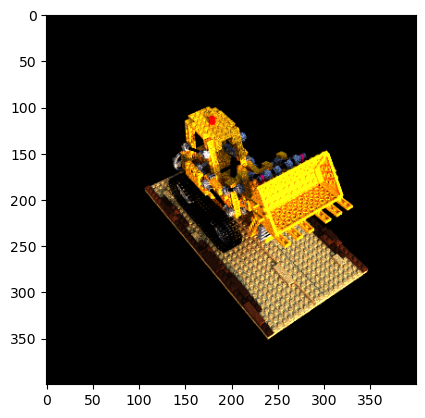

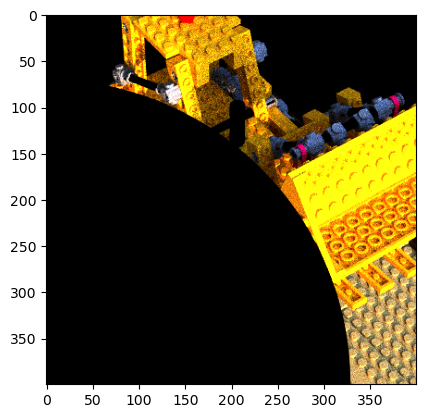

In [32]:
import matplotlib.pyplot as plt

visualize_integrator(L, active, [400,400,1111])
visualize_integrator(L_po, active_po, [400,400,1111])



In [13]:
import visu3d as v3d 

rays = v3d.Ray(pos = r4[::100,:3], dir=r4[::100,3:])
rays.fig

In [18]:
np.max(np.array(pos))

799.907

In [12]:
img = mi.render(scene, sensor=sensor)
mi.Bitmap(img)

Bitmap[
  pixel_format = rgb,
  component_format = float32,
  size = [800, 800],
  srgb_gamma = 0,
  struct = Struct<12>[
    float32 R; // @0, premultiplied alpha
    float32 G; // @4, premultiplied alpha
    float32 B; // @8, premultiplied alpha
  ],
  data = [ 7.32 MiB of image data ]
]

In [94]:
import torch
spp = 20
H, W, f  = [800,800,1111]
Hl = torch.arange(H) - H//2
Wl = torch.arange(W) - W//2
unif_samps = torch.rand(H,W,spp*2)*(Hl[1] - Hl[0])
grid_x, grid_y = torch.meshgrid(Wl, Hl)

grid_x_spp = unif_samps[:,:,:spp] + grid_x.unsqueeze(-1)
grid_y_spp = unif_samps[:,:,spp:] + grid_y.unsqueeze(-1)

rays_spp = torch.stack((grid_x_spp/f, -grid_y_spp/f, -1*torch.ones_like(grid_x_spp))).float()
rays_spp = rays_spp.permute(0,2,1,3)
rays_spp = torch.reshape(rays_spp, (3,-1))

In [104]:
from utils.xyz import rays_single_cam
rays_single = rays_single_cam([800,800, 1111])

In [108]:

import visu3d as v3d 

ray_spp_test = v3d.Ray(pos = np.zeros((rays_spp.shape[1]//100, 3)), dir = rays_spp.t()[::100].numpy())

ray_cam = v3d.Ray(pos = np.zeros((rays_single.shape[1], 3)), dir=rays_single.t().numpy())
ray_spp_test.fig
# ray_cam.fig

In [26]:
integrator = mi.load_dict({'type':'prb',
						   'max_depth': 8,
						   'hide_emitters': True})

In [27]:
integrator.sample

PRBIntegrator[max_depth = 8, rr_depth = 5]